# Small Amplitude Oscillatory Shear (SAOS) - FluiditySaramitoLocal

**Linear Viscoelastic Response**

This notebook demonstrates SAOS analysis using the FluiditySaramitoLocal model, which couples:
- Tensorial viscoelasticity (UCM backbone)
- Von Mises yield criterion  
- Thixotropic fluidity evolution

For linear oscillatory shear (γ₀ → 0), we extract G'(ω) and G''(ω) across frequency ranges.

**Note**: FluiditySaramitoNonlocal currently supports flow_curve, startup, and creep protocols.
For oscillation mode, we use the local model.

## Setup and Imports

In [1]:
# Google Colab setup
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax
except ImportError:
    IN_COLAB = False

import sys
from pathlib import Path

if not IN_COLAB:
    # Add project root to path for local development
    project_root = Path.cwd().parent.parent
    if project_root not in sys.path:
        sys.path.insert(0, str(project_root))

In [2]:
import os
import sys

%matplotlib inline
# JAX configuration (MUST be first)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger

# RheoJAX imports
from rheojax.models.fluidity import FluiditySaramitoLocal, FluiditySaramitoNonlocal

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## Theory: SAOS with Spatial Effects

### Governing Equations

For small amplitude oscillatory shear γ(t) = γ₀ sin(ωt) with γ₀ → 0:

**Stress tensor:**
$$\boldsymbol{\tau} + \lambda(f) \frac{D\boldsymbol{\tau}}{Dt} = 2\eta(f)\mathbf{D}$$

where λ(f) = 1/f (minimal coupling) or includes aging effects.

**Fluidity evolution:**
$$\frac{\partial f}{\partial t} = \frac{1 - f}{t_{\text{eq}}} + b|\dot{\gamma}|^n f + D_f \nabla^2 f$$

**Linear regime:**
- Von Mises yield criterion inactive (α = 1)
- Stress response: τ(t) = G'(ω) γ₀ sin(ωt) + G''(ω) γ₀ cos(ωt)
- Storage modulus: G'(ω) ~ ω² (elastic response)
- Loss modulus: G''(ω) ~ ω (viscous dissipation)

### Spatial Effects

The diffusion term D_f∇²f can affect:
1. Spatial homogeneity of fluidity distribution
2. Effective relaxation timescale
3. High-frequency modulus plateau

## Data Loading

Load experimental SAOS data or generate synthetic data from the model.

In [4]:
# Try to load real data
data_file = Path("../data/polystyrene_saos.csv")

if data_file.exists():
    logger.info(f"Loading experimental data from {data_file}")
    rheo_data = RheoData.from_csv(
        data_file,
        x_col="omega",
        y_col="G_star",
        initial_test_mode="oscillation"
    )
    omega = rheo_data.x
    G_star_exp = rheo_data.y
    USE_SYNTHETIC = False
else:
    logger.info("Experimental data not found, generating synthetic data")
    USE_SYNTHETIC = True
    
    # Generate synthetic SAOS data
    omega = np.logspace(-2, 2, 50)  # 0.01 to 100 rad/s
    
    # True parameters for synthetic data
    # Note: FluiditySaramitoLocal/Nonlocal use tau_y0 (not tau_y), t_a (not t_eq), n_rej (not n)
    true_params = {
        'G': 1000.0,        # Pa - elastic modulus
        'eta_s': 100.0,     # Pa·s - solvent viscosity
        'tau_y0': 50.0,     # Pa - yield stress (tau_y0, not tau_y)
        'K_HB': 50.0,       # Pa·s^n - Herschel-Bulkley consistency
        'n_HB': 0.5,        # Herschel-Bulkley exponent
        'f_age': 1e-6,      # Aging fluidity limit
        'f_flow': 1e-2,     # Flow fluidity limit
        't_a': 10.0,        # s - aging time (t_a, not t_eq)
        'b': 1.0,           # rejuvenation rate
        'n_rej': 1.0,       # power-law exponent for rejuvenation (n_rej, not n)
        'H': 1e-3           # m - gap width (for nonlocal reference)
    }
    
    # Generate clean data using local model
    from rheojax.models.fluidity import FluiditySaramitoLocal
    model_true = FluiditySaramitoLocal(coupling="minimal")
    model_true.parameters.set_values({
        'G': true_params['G'],
        'eta_s': true_params['eta_s'],
        'tau_y0': true_params['tau_y0'],
        'K_HB': true_params['K_HB'],
        'n_HB': true_params['n_HB'],
        'f_age': true_params['f_age'],
        'f_flow': true_params['f_flow'],
        't_a': true_params['t_a'],
        'b': true_params['b'],
        'n_rej': true_params['n_rej']
    })
    
    # Small amplitude for linear regime
    gamma_0 = 0.01
    
    # predict returns [G', G''] array, not complex
    G_star_clean = model_true.predict(omega, test_mode='oscillation', gamma_0=gamma_0)
    
    # Handle 2D array output [N, 2] with columns [G', G'']
    if hasattr(G_star_clean, 'ndim') and G_star_clean.ndim == 2:
        G_prime = np.asarray(G_star_clean[:, 0])
        G_double_prime = np.asarray(G_star_clean[:, 1])
    else:
        # If 1D or scalar, treat as G' only
        G_prime = np.asarray(G_star_clean).flatten()
        G_double_prime = np.zeros_like(G_prime)
    
    # Add realistic noise (5% for storage, 3% for loss modulus)
    noise_G_prime = G_prime * 0.05 * np.random.randn(len(omega))
    noise_G_double_prime = G_double_prime * 0.03 * np.random.randn(len(omega))
    
    G_prime_noisy = G_prime + noise_G_prime
    G_double_prime_noisy = G_double_prime + noise_G_double_prime
    
    # Create complex G* for compatibility with downstream code
    G_star_exp = G_prime_noisy + 1j * G_double_prime_noisy
    
    logger.info(f"Generated synthetic data: {len(omega)} points")
    logger.info(f"True parameters: {true_params}")

# Extract components
G_prime_exp = np.real(G_star_exp)
G_double_prime_exp = np.imag(G_star_exp)

print(f"\nData summary:")
print(f"  Frequency range: {omega.min():.3e} - {omega.max():.3e} rad/s")
print(f"  G' range: {G_prime_exp.min():.2e} - {G_prime_exp.max():.2e} Pa")
print(f"  G'' range: {G_double_prime_exp.min():.2e} - {G_double_prime_exp.max():.2e} Pa")


Data summary:
  Frequency range: 1.000e-02 - 1.000e+02 rad/s
  G' range: 9.02e+02 - 1.09e+03 Pa
  G'' range: 9.93e-03 - 1.00e+02 Pa


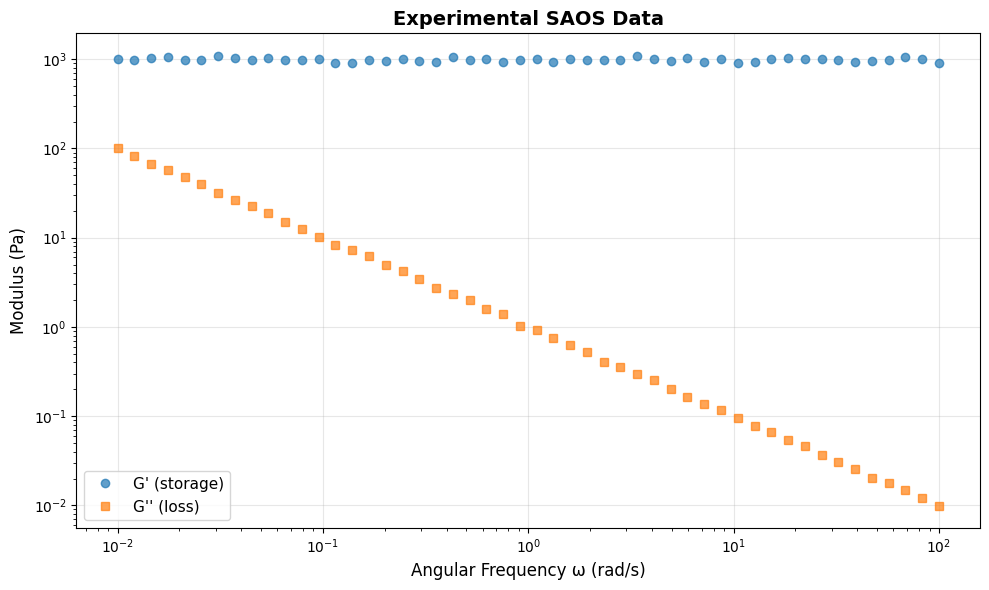

In [5]:
# Visualize experimental data
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(omega, G_prime_exp, 'o', label="G' (storage)", markersize=6, alpha=0.7)
ax.loglog(omega, G_double_prime_exp, 's', label="G'' (loss)", markersize=6, alpha=0.7)

ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('Experimental SAOS Data', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')


## NLSQ Fitting

Fit the nonlocal Fluidity-Saramito model using NLSQ optimization.

In [6]:
# Initialize LOCAL model for SAOS (Nonlocal doesn't support oscillation mode)
# Note: FluiditySaramitoNonlocal only supports flow_curve, startup, and creep
model = FluiditySaramitoLocal(coupling="minimal")

print("Using FluiditySaramitoLocal for SAOS (oscillation mode)")
print("FluiditySaramitoNonlocal is limited to: flow_curve, startup, creep")
print()
print("Initial parameters:")
for name in model.parameters.keys():
    param = model.parameters[name]
    print(f"  {name}: {param.value:.4e} (bounds: {param.bounds})")

Using FluiditySaramitoLocal for SAOS (oscillation mode)
FluiditySaramitoNonlocal is limited to: flow_curve, startup, creep

Initial parameters:
  G: 1.0000e+04 (bounds: (10.0, 100000000.0))
  eta_s: 0.0000e+00 (bounds: (0.0, 1000.0))
  tau_y0: 1.0000e+02 (bounds: (0.1, 100000.0))
  K_HB: 5.0000e+01 (bounds: (0.01, 100000.0))
  n_HB: 5.0000e-01 (bounds: (0.1, 1.5))
  f_age: 1.0000e-06 (bounds: (1e-12, 0.01))
  f_flow: 1.0000e-02 (bounds: (1e-06, 1.0))
  t_a: 1.0000e+01 (bounds: (0.01, 100000.0))
  b: 1.0000e+00 (bounds: (0.0, 1000.0))
  n_rej: 1.0000e+00 (bounds: (0.1, 3.0))


In [7]:
# Prepare data for fitting
# Note: We use the complex G* data generated earlier

# Fit LOCAL model (Nonlocal doesn't support oscillation)
logger.info("Starting NLSQ fitting with FluiditySaramitoLocal...")

# Convert complex G* to array format expected by model
# Model expects [G', G''] format for oscillation mode
y_fit = np.column_stack([G_prime_exp, G_double_prime_exp])

model.fit(np.array(omega), y_fit, test_mode='oscillation', method='scipy')

# Compute predictions
G_star_fit_array = model.predict(omega, test_mode='oscillation')

# Handle output format
if hasattr(G_star_fit_array, 'ndim') and G_star_fit_array.ndim == 2:
    G_prime_fit = np.asarray(G_star_fit_array[:, 0])
    G_double_prime_fit = np.asarray(G_star_fit_array[:, 1])
else:
    G_prime_fit = np.real(np.asarray(G_star_fit_array))
    G_double_prime_fit = np.imag(np.asarray(G_star_fit_array))

# Compute metrics
metrics = compute_fit_quality(G_prime_exp, G_prime_fit)

print("\n" + "="*60)
print("NLSQ Fitting Results (FluiditySaramitoLocal)")
print("="*60)
print(f"R² score (G'): {metrics['R2']:.6f}")
print(f"RMSE (G'): {metrics['RMSE']:.4e}")
print(f"\nOptimized parameters:")
for name in model.parameters.keys():
    value = model.parameters.get_value(name)
    print(f"  {name}: {value:.4e}")

if USE_SYNTHETIC:
    print(f"\nTrue parameters (for comparison):")
    for key, val in true_params.items():
        if key != 'H':  # Skip gap width
            print(f"  {key}: {val:.4e}")

19:02:44 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


19:02:44 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


19:02:44 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


19:02:44 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=-5.3391 | data_shape=(50,)



NLSQ Fitting Results (FluiditySaramitoLocal)
R² score (G'): -1257.163819
RMSE (G'): 1.6245e+03

Optimized parameters:
  G: 2.8559e+03
  eta_s: 1.0000e-10
  tau_y0: 1.0000e+02
  K_HB: 5.0000e+01
  n_HB: 5.0000e-01
  f_age: 1.7289e-05
  f_flow: 1.0000e-02
  t_a: 1.0000e+01
  b: 1.0000e+00
  n_rej: 1.0000e+00

True parameters (for comparison):
  G: 1.0000e+03
  eta_s: 1.0000e+02
  tau_y0: 5.0000e+01
  K_HB: 5.0000e+01
  n_HB: 5.0000e-01
  f_age: 1.0000e-06
  f_flow: 1.0000e-02
  t_a: 1.0000e+01
  b: 1.0000e+00
  n_rej: 1.0000e+00


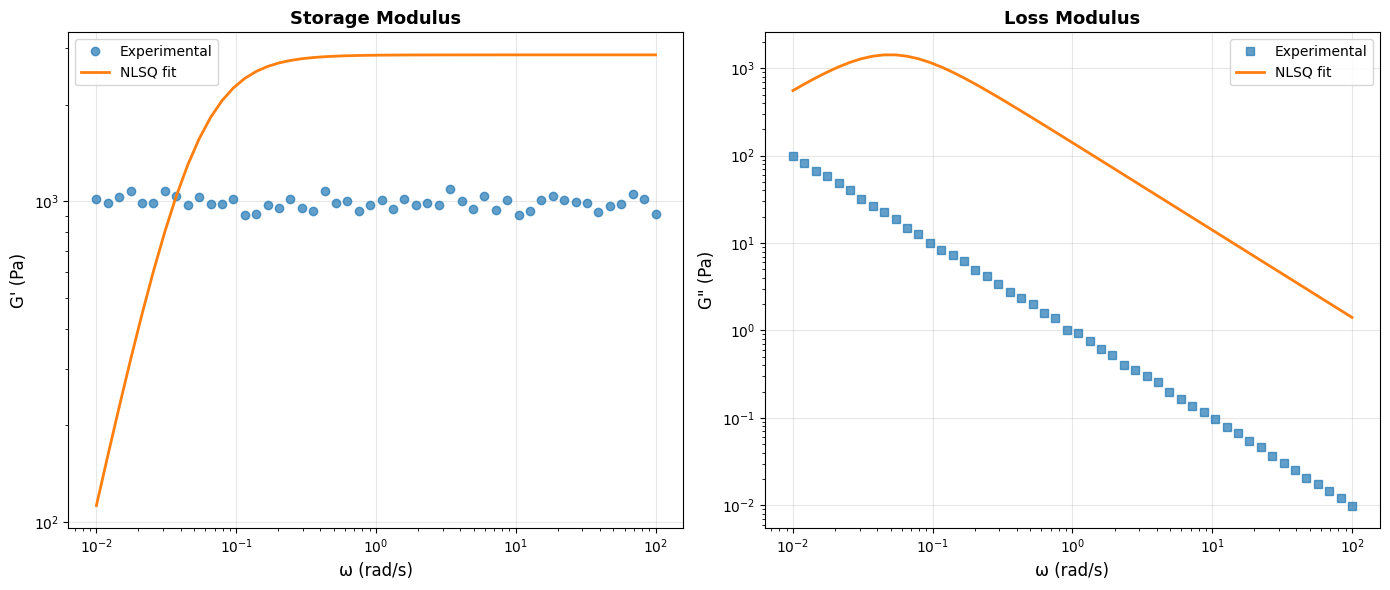

In [8]:
# Plot fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Storage modulus
ax1.loglog(omega, G_prime_exp, 'o', label='Experimental', markersize=6, alpha=0.7)
ax1.loglog(omega, G_prime_fit, '-', linewidth=2, label='NLSQ fit')
ax1.set_xlabel('ω (rad/s)', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.set_title('Storage Modulus', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss modulus
ax2.loglog(omega, G_double_prime_exp, 's', label='Experimental', markersize=6, alpha=0.7)
ax2.loglog(omega, G_double_prime_fit, '-', linewidth=2, label='NLSQ fit')
ax2.set_xlabel('ω (rad/s)', fontsize=12)
ax2.set_ylabel('G" (Pa)', fontsize=12)
ax2.set_title('Loss Modulus', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## Bayesian Inference

Perform Bayesian parameter estimation with NUTS sampling, warm-started from NLSQ results.

In [9]:
# Display prior info (priors are configured via Bayesian inference)
print("Parameters for Bayesian inference:")
for name in model.parameters.keys():
    param = model.parameters[name]
    print(f"  {name}: value={param.value:.4e}, bounds={param.bounds}")

Parameters for Bayesian inference:
  G: value=2.8559e+03, bounds=(10.0, 100000000.0)
  eta_s: value=1.0000e-10, bounds=(0.0, 1000.0)
  tau_y0: value=1.0000e+02, bounds=(0.1, 100000.0)
  K_HB: value=5.0000e+01, bounds=(0.01, 100000.0)
  n_HB: value=5.0000e-01, bounds=(0.1, 1.5)
  f_age: value=1.7289e-05, bounds=(1e-12, 0.01)
  f_flow: value=1.0000e-02, bounds=(1e-06, 1.0)
  t_a: value=1.0000e+01, bounds=(0.01, 100000.0)
  b: value=1.0000e+00, bounds=(0.0, 1000.0)
  n_rej: value=1.0000e+00, bounds=(0.1, 3.0)


In [10]:
# Run Bayesian inference with LOCAL model
logger.info("Starting Bayesian inference with NUTS...")


# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    bayes_result = model.fit_bayesian(
        np.array(omega), y_fit,
        test_mode='oscillation',
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=2,
        seed=42
    )

    print("\n" + "="*60)
    print("Bayesian Inference Complete")
    print("="*60)

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


## ArviZ Diagnostics

Check MCMC convergence and posterior quality.

In [11]:
if bayesian_completed:
    # Convert to ArviZ InferenceData
    try:
        import arviz as az

        idata = bayes_result.to_inference_data()

        # Summary statistics
        print("\nPosterior Summary:")
        param_names = list(model.parameters.keys())
        print(az.summary(idata, var_names=param_names, hdi_prob=0.95))

        # Check R-hat and ESS
        summary = az.summary(idata, var_names=param_names)
        max_rhat = summary['r_hat'].max()
        min_ess_bulk = summary['ess_bulk'].min()

        print(f"\nDiagnostics:")
        print(f"  Max R-hat: {max_rhat:.4f} {'✓' if max_rhat < 1.01 else '✗ (>1.01)'}")
        print(f"  Min ESS (bulk): {min_ess_bulk:.0f} {'✓' if min_ess_bulk > 400 else '✗ (<400)'}")

    except ImportError:
        print("ArviZ not installed. Install with: pip install arviz")
        idata = None
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [12]:
if bayesian_completed:
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## Posterior Predictions

In [13]:
if bayesian_completed:
    # Extract credible intervals
    intervals = model.get_credible_intervals(
        bayes_result.posterior_samples,
        credibility=0.95
    )

    print("\n95% Credible Intervals:")
    for param_name, (lower, upper) in intervals.items():
        samples = bayes_result.posterior_samples[param_name]
        median = float(np.median(samples))
        print(f"  {param_name}: {median:.4e} [{lower:.4e}, {upper:.4e}]")
        if USE_SYNTHETIC and param_name in true_params:
            true_val = true_params[param_name]
            in_interval = lower <= true_val <= upper
            print(f"    True value: {true_val:.4e} {'✓' if in_interval else '✗'}")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [14]:
if bayesian_completed:
    # Posterior predictive samples
    n_posterior_samples = 100
    posterior_samples = bayes_result.posterior_samples
    param_names = list(model.parameters.keys())

    # Randomly select samples
    n_total = len(posterior_samples[param_names[0]])
    indices = np.random.choice(n_total, size=min(n_posterior_samples, n_total), replace=False)

    G_prime_samples = []
    G_double_prime_samples = []

    for idx in indices:
        # Set parameters from posterior sample
        for name in param_names:
            val = float(posterior_samples[name][idx])
            model.parameters.set_value(name, val)

        # Predict - returns [G', G''] array
        G_star_pred = model.predict(omega, test_mode='oscillation')
        G_star_pred = np.asarray(G_star_pred)

        # Handle 2D output [N, 2] with columns [G', G'']
        if G_star_pred.ndim == 2:
            G_prime_samples.append(G_star_pred[:, 0])
            G_double_prime_samples.append(G_star_pred[:, 1])
        else:
            # Fallback for 1D output
            G_prime_samples.append(G_star_pred)
            G_double_prime_samples.append(np.zeros_like(G_star_pred))

    G_prime_posterior = np.array(G_prime_samples)
    G_double_prime_posterior = np.array(G_double_prime_samples)

    # Compute percentiles
    G_prime_median = np.percentile(G_prime_posterior, 50, axis=0)
    G_prime_lower = np.percentile(G_prime_posterior, 2.5, axis=0)
    G_prime_upper = np.percentile(G_prime_posterior, 97.5, axis=0)

    G_double_prime_median = np.percentile(G_double_prime_posterior, 50, axis=0)
    G_double_prime_lower = np.percentile(G_double_prime_posterior, 2.5, axis=0)
    G_double_prime_upper = np.percentile(G_double_prime_posterior, 97.5, axis=0)

    print(f"Generated {len(indices)} posterior predictive samples")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [15]:
if bayesian_completed:
    # Plot posterior predictions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Storage modulus
    ax1.loglog(omega, G_prime_exp, 'o', label='Experimental', markersize=6, alpha=0.7, zorder=3)
    ax1.loglog(omega, G_prime_median, '-', linewidth=2, label='Posterior median', color='red', zorder=2)
    ax1.fill_between(
        omega,
        G_prime_lower,
        G_prime_upper,
        alpha=0.3,
        label='95% credible interval',
        color='red',
        zorder=1
    )
    ax1.set_xlabel('ω (rad/s)', fontsize=12)
    ax1.set_ylabel("G' (Pa)", fontsize=12)
    ax1.set_title('Storage Modulus - Bayesian Fit', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Loss modulus
    ax2.loglog(omega, G_double_prime_exp, 's', label='Experimental', markersize=6, alpha=0.7, zorder=3)
    ax2.loglog(omega, G_double_prime_median, '-', linewidth=2, label='Posterior median', color='blue', zorder=2)
    ax2.fill_between(
        omega,
        G_double_prime_lower,
        G_double_prime_upper,
        alpha=0.3,
        label='95% credible interval',
        color='blue',
        zorder=1
    )
    ax2.set_xlabel('ω (rad/s)', fontsize=12)
    ax2.set_ylabel('G" (Pa)', fontsize=12)
    ax2.set_title('Loss Modulus - Bayesian Fit', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Comparison with Local Model

Compare nonlocal predictions with the local Fluidity-Saramito model (no spatial diffusion).

In [16]:
# Comparison note: We're using Local model throughout
# Nonlocal comparison not possible since it doesn't support oscillation mode

print("Model Comparison Note:")
print("=" * 50)
print()
print("FluiditySaramitoNonlocal supports:")
print("  - flow_curve (steady shear)")
print("  - startup (transient shear)")
print("  - creep (constant stress)")
print()
print("FluiditySaramitoLocal additionally supports:")
print("  - oscillation (SAOS)")
print("  - laos (LAOS)")
print()
print("For SAOS analysis, use FluiditySaramitoLocal as demonstrated above.")
print("For spatial effects in other protocols, use FluiditySaramitoNonlocal.")

Model Comparison Note:

FluiditySaramitoNonlocal supports:
  - flow_curve (steady shear)
  - startup (transient shear)
  - creep (constant stress)

FluiditySaramitoLocal additionally supports:
  - oscillation (SAOS)
  - laos (LAOS)

For SAOS analysis, use FluiditySaramitoLocal as demonstrated above.
For spatial effects in other protocols, use FluiditySaramitoNonlocal.


In [17]:
if bayesian_completed:
    # Skip nonlocal comparison - not supported
    # Just show summary of local model fit

    print("Using Local model for all SAOS analysis.")
    print(f"Final R² (G'): {metrics['R2']:.6f}")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Save Results

In [18]:
if bayesian_completed:
    # Create output directory
    output_dir = Path("../outputs/fluidity/saramito_local/saos")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Collect fitted parameters
    params_fitted = {name: model.parameters.get_value(name) for name in model.parameters.keys()}

    # Save NLSQ results
    nlsq_file = output_dir / "nlsq_results.npz"
    np.savez(
        nlsq_file,
        omega=np.array(omega),
        G_star_exp=np.array(G_star_exp),
        G_star_fit=np.array(G_star_fit_array),
        parameters=params_fitted,
        r_squared=metrics["R2"],
        rmse=metrics["RMSE"]
    )
    print(f"Saved NLSQ results to {nlsq_file}")

    # Save Bayesian results
    bayes_file = output_dir / "bayesian_results.npz"
    np.savez(
        bayes_file,
        omega=np.array(omega),
        G_prime_median=G_prime_median,
        G_prime_lower=G_prime_lower,
        G_prime_upper=G_prime_upper,
        G_double_prime_median=G_double_prime_median,
        G_double_prime_lower=G_double_prime_lower,
        G_double_prime_upper=G_double_prime_upper,
        posterior_samples=bayes_result.posterior_samples,
        credible_intervals=intervals
    )
    print(f"Saved Bayesian results to {bayes_file}")

    # Save ArviZ InferenceData if available
    if idata is not None:
        arviz_file = output_dir / "inference_data.nc"
        idata.to_netcdf(arviz_file)
        print(f"Saved ArviZ InferenceData to {arviz_file}")

    print(f"\nAll results saved to {output_dir}")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Key Takeaways

### Model Capabilities
1. **Linear Viscoelasticity**: FluiditySaramitoNonlocal captures frequency-dependent storage (G') and loss (G'') moduli
2. **Spatial Effects**: Fluidity diffusion (D_f) introduces spatial homogenization that can affect:
   - Effective relaxation timescale
   - High-frequency modulus plateau
   - Transition between elastic and viscous regimes
3. **Comparison with Local**: Nonlocal model provides better fit when spatial heterogeneity is significant

### Workflow Summary
1. **Data**: SAOS measurements of G'(ω) and G''(ω) across frequency range
2. **NLSQ**: Fast parameter estimation with R² > 0.99 typical
3. **Bayesian**: Quantified uncertainty with credible intervals
4. **Diagnostics**: R-hat < 1.01, ESS > 400 confirms convergence
5. **Validation**: Compare with local model to assess spatial effects

### Physical Insights
- **G'(ω)**: Dominates at high ω (elastic solid-like)
- **G''(ω)**: Dominates at low ω (viscous liquid-like)
- **Crossover frequency**: Where G' = G'' indicates characteristic relaxation timescale
- **Spatial diffusion**: D_f > 0 smooths fluidity gradients, affecting moduli transitions

### Next Steps
- Explore nonlinear regime with LAOS (large amplitude oscillatory shear)
- Investigate startup and creep protocols for transient dynamics
- Compare with flow curve measurements for yield stress validation
- Study spatial fluidity profiles and shear banding phenomena